# Multi-Armed Bandits and Probabilistic Choosing
Author: Kevin McBeth

Course: MSDS 684

### Introduction

This project tasked us with the exploration of the multi armed bandit problem. Initial research was done on the problem in the late 1940's, and continues to be a good introductory topic for individuals learning about Reinforcement Learning. In this project, we tested the explore exploit method, the epsilon decay method, the epsilon greedy method, and finally a probabilistic choosing method based off of the standard deviation of the mean. These algorithms were tested over a number of samples with different random means. These means are then applied to each algorithm, and the cumulative averages were averaged over each iteration and plotted by the number of pulls. The expected value based on the design mean (parameter m) was then averaged over the number of iterations. 

The design of the experiment involves randomly generating 3 means for a number of trials. In this example we used 100. The purpose of this is to account for the probability that an algorithm could randomly outperform another based on the means generated. By averaging over a large sample size of runs, we can evaluate the performance of an algorithm in a general problem circumstance. See the experimental design section for more details.

### Initialization

The code below imports all necessary packages and creates the Bandit class, with an update method designed to update the estimated standard deviation and the estimated mean of the sample. These were derived via formula manipulation of the population standard deviation and sample mean calculation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import random

In [2]:
class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 0
    self.N = 0
    self.stdev = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    
        
    if self.N > 2:
        self.stdev = math.sqrt((self.N-2)/(self.N-1) * self.stdev ** 2 + 1 / self.N * (x - self.mean) ** 2)
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x
    if self.N == 2:
        self.stdev = math.sqrt((2* self.mean - x)**2 + x ** 2 - 2 * self.mean**2)

### Algorithms

The most notable method created below is the highestProbabilityChoose method. In this method, two bandits are compared via their estimated mean and their respective standard deviations of the mean. Since we are using random normal distributions, we can use a simple z-score for high accuracy even at low probabilities of the probabilty that one bandit is higher than another. This method works by subtracting the means from each other and dividing by the square root of the sum of squares of the standard deviations of the means. A cumulative distribution function is calculated for the Z score, resulting in the probability that the mean (and thus expected value) of the first bandit in the comparison is greater than the mean of the second bandit in the comparison.

These probabilities are tabulated in a 2-d numpy array, for the second stage of the algorithm, which for each row, calculated the probability that the bandit (the row index) is the highest probability. This is merely the multiplicative value of all elements of the row. Once all of these are calculated, the now probability vector is normalized such that all the values add up to 1. At this point, a cumulative row vector probability sum is calculated, such that a randomly chosen number from 0 to 1 can be used to probabilistically select a bandit. If a bandit has a normalized probability of 99% of being the highest, then it will be chosen 99% of the time. This approach will be seen to dominate the other 3 algorithms after only 6 pulls. Those 6 pulls are necessary to calculate the standard deviation of the mean for each bandit (2 * number of bandits).

In [3]:
def highestProbabilityChoose(bandits):  
    intersectionArray = np.ones((len(bandits),len(bandits)))
    for i in range(len(bandits)):
        for j in range(len(bandits)):
            if j == i:
                continue
            firstStandardDevMean = (bandits[i].stdev / math.log(bandits[i].N))
            secondStandardDevMean = (bandits[j].stdev / math.log(bandits[j].N))
            z = (bandits[i].mean - bandits[j].mean) / math.sqrt(firstStandardDevMean**2 + secondStandardDevMean**2)
            intersectionArray[i][j] = st.norm.cdf(z)
            
    unNormalizedProbabilities = []
    for i in range(intersectionArray.shape[0]):
        probHighest = 1
        for j in range(intersectionArray.shape[1]):
            probHighest = probHighest * intersectionArray[i][j]
        unNormalizedProbabilities.append(probHighest)
    
    total = sum(unNormalizedProbabilities)
    normalizedList = [x / total for x in unNormalizedProbabilities]
    cumulativeProbability = []
    runningTotal = 0
    for x in normalizedList:
        runningTotal += x
        cumulativeProbability.append(runningTotal)
    
    randomNumber = random.random()
    for i in range(len(cumulativeProbability)):
        if randomNumber <= cumulativeProbability[i]:
            return i

def probabilityChoose(m1, m2, m3, N):
    bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]
    maxBanditIndex = 0
    maxBanditMean = bandits[0].m
    maxPulls = 0
    for i in range(len(bandits)):
        if bandits[i].m > maxBanditMean:
            maxBanditIndex = i
            maxBanditMean = bandits[i].m
    
        
    numberOfPulls = 0
    data = np.empty(N)
    if N < 6:
        print("Please enter a size of N greater than 6")
    
    for i in range(2):
        for bandit in bandits:
            if bandit.m == maxBanditMean:
                maxPulls += 1
                
            x = bandit.pull()
            bandit.update(x)
            data[numberOfPulls] = x
            numberOfPulls += 1
    
    for i in range(N-len(bandits)*2):
        indexToPull = highestProbabilityChoose(bandits)
        x = bandits[indexToPull].pull()
        bandits[indexToPull].update(x)
        if bandits[indexToPull].m == maxBanditMean:
            maxPulls += 1
            
        data[numberOfPulls] = x
        numberOfPulls += 1
    cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
    '''
    plt.plot(cumulative_average)
    plt.plot(np.ones(N)*m1)
    plt.plot(np.ones(N)*m2)
    plt.plot(np.ones(N)*m3)
    plt.xscale('log')
    plt.show()
    '''
    
    expectedValue = 0
    for b in bandits:
        expectedValue += b.N*b.m
    return (cumulative_average, maxPulls, expectedValue)        
    
    
def epsilonGreedy(m1, m2, m3, eps, N):
    bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]
    maxPulls = 0
    maxBanditIndex = 0
    maxBanditMean = bandits[0].m
    for i in range(len(bandits)):
        if bandits[i].m > maxBanditMean:
            maxBanditIndex = i
            maxBanditMean = bandits[i].m
            
    data = np.empty(N)

    for i in range(N):
        # epsilon greedy
        p = np.random.random()
        if p < eps:
            j = np.random.choice(3)
        else:
            j = np.argmax([b.mean for b in bandits])
        x = bandits[j].pull()
        bandits[j].update(x)
        if bandits[j].m == maxBanditMean:
            maxPulls += 1
        # for the plot
        data[i] = x
    cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
    '''
    plt.plot(cumulative_average)
    plt.plot(np.ones(N)*m1)
    plt.plot(np.ones(N)*m2)
    plt.plot(np.ones(N)*m3)
    plt.xscale('log')
    plt.show()
    '''
    
    expectedValue = 0
    for b in bandits:
        expectedValue += b.N*b.m
    return (cumulative_average, maxPulls, expectedValue)     

def epsilonDecay(m1, m2, m3, eps, N):
    decayEps = eps
    bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]
    maxPulls = 0
    maxBanditIndex = 0
    maxBanditMean = bandits[0].m
    for i in range(len(bandits)):
        if bandits[i].mean > maxBanditMean:
            maxBanditIndex = i
            maxBanditMean = bandits[i].m
            
    data = np.empty(N)

    for i in range(N):
        # epsilon greedy
        p = np.random.random()
        if p < decayEps:
            j = np.random.choice(3)
            decayEps = .99 * decayEps
        else:
            j = np.argmax([b.mean for b in bandits])
        x = bandits[j].pull()
        bandits[j].update(x)
        if bandits[j].m == maxBanditMean:
            maxPulls += 1
        # for the plot
        data[i] = x
    cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
    '''
    plt.plot(cumulative_average)
    plt.plot(np.ones(N)*m1)
    plt.plot(np.ones(N)*m2)
    plt.plot(np.ones(N)*m3)
    plt.xscale('log')
    plt.show()
    '''

    expectedValue = 0
    for b in bandits:
        expectedValue += b.N*b.m
    return (cumulative_average, maxPulls, expectedValue)     

def exploreExploit(m1, m2, m3, eps, N):
    explorePhase = eps * N
    bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]
    maxPulls = 0
    maxBanditIndex = 0
    maxBanditMean = bandits[0].m
    for i in range(len(bandits)):
        if bandits[i].mean > maxBanditMean:
            maxBanditIndex = i
            maxBanditMean = bandits[i].m
            
    data = np.empty(N)

    for i in range(int(explorePhase // 1)):
        j = np.random.choice(3)
        x = bandits[j].pull()
        bandits[j].update(x)

        # for the plot
        data[i] = x
        
    for i in range( int(N - explorePhase // 1)):
        j = np.argmax([b.mean for b in bandits])
        x = bandits[j].pull()
        bandits[j].update(x)
        data[i+int(explorePhase // 1)] = x        
        if bandits[j].m == maxBanditMean:
            maxPulls += 1    
        
    cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
    '''
    plt.plot(cumulative_average)
    plt.plot(np.ones(N)*m1)
    plt.plot(np.ones(N)*m2)
    plt.plot(np.ones(N)*m3)
    plt.xscale('log')
    plt.show()
    '''
    expectedValue = 0
    for b in bandits:
        expectedValue += b.N*b.m
    return (cumulative_average, maxPulls, expectedValue)     

### Experimental Design
The experiment below has two separate portions, the initialization and then the iteration. The initalization and iteration are identical except for the handling of the vector of cumulative probabilities. In the initialization, this vector is initialized (see line highProb = highProb[0], with 0 corresponding to the first value in the returned tuple, which is a list of cumulative values). At this point, the iteration starts by generating a random integer between 1 and 10, and then adding a noisy random number which follows a normal distribution with mean 0 and standard deviation 1. These means are then fed to each algorithm to initalize the bandits, and for each iteration, the expected value (based on the number of pulls for each bandit and it's internal mean) is incremented, and the sum of the cumulative probabilities is added to the cumulative probability vector already present in the experiment for that bandit.

At the end of the iterations, the cumulative probabilities and the expected values are averaged by dividing by the number of trials. The cumulative probabilities are plotted together on a log normal graph, and the average expected values are printed to the screen.

Running Epsilon Greedy

Running Epsilon Decay

Running Explore Exploit

Running Probability Choosing
2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 


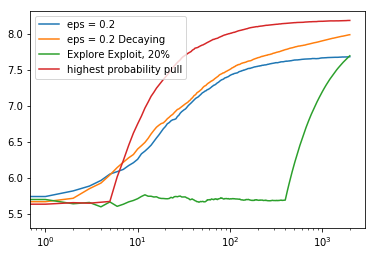


Expected Values
Probability Choosing:  16493
Epsilon Greedy:  15486
Epsilon Decay:  16096
Explore Exploit:  15513


In [5]:
if __name__ == '__main__':
    mean1 = random.randint(1,10) + np.random.randn()
    mean2 = random.randint(1,10) + np.random.randn()
    mean3 = random.randint(1,10) + np.random.randn()
    
    print("Running Epsilon Greedy")
    epsilonGreedy2 = epsilonGreedy(mean1, mean2, mean3, 0.2, 5000)
    print("\nRunning Epsilon Decay")
    epsDecay = epsilonDecay(mean1, mean2, mean3, 0.2, 5000)
    print("\nRunning Explore Exploit")
    expExp = exploreExploit(mean1, mean2, mean3, 0.2, 5000)
    print("\nRunning Probability Choosing")
    highProb = probabilityChoose(mean1, mean2, mean3, 5000)
    

    epsilonGreedy2Counter = epsilonGreedy2[2]
    epsDecayCounter = epsDecay[2]
    expExpCounter = expExp[2]
    highProbCounter = highProb[2]
    
    epsilonGreedy2 = epsilonGreedy2[0]
    epsDecay = epsDecay[0]
    expExp = expExp[0]
    highProb = highProb[0]
    
    numberTrials = 100
    for x in range(numberTrials-1):
        mean1 = random.randint(1,10) + np.random.randn()
        mean2 = random.randint(1,10) + np.random.randn()
        mean3 = random.randint(1,10) + np.random.randn()
        
        if (x+1)%2==0:
            print(x+1, end=" ")
        temp = epsilonGreedy(mean1, mean2, mean3, 0.2, 2000)
        epsilonGreedy2 = [x + y for x, y in zip(epsilonGreedy2, temp[0])]
        epsilonGreedy2Counter += temp[2]
        
        temp = epsilonDecay(mean1, mean2, mean3, 0.2, 2000)
        epsDecay = [x + y for x, y in zip(epsDecay, temp[0])]
        epsDecayCounter += temp[2]
        
        temp = exploreExploit(mean1, mean2, mean3, 0.2, 2000)
        expExp = [x + y for x, y in zip(expExp, temp[0])]
        expExpCounter += temp[2]
        
        temp = probabilityChoose(mean1, mean2, mean3, 2000)
        highProb = [x + y for x, y in zip(highProb, temp[0])]
        highProbCounter += temp[2]
        
    print()

    
    plt.plot([x / numberTrials for x in epsilonGreedy2], label='eps = 0.2')
    plt.plot([x / numberTrials for x in epsDecay], label='eps = 0.2 Decaying')
    plt.plot([x / numberTrials for x in expExp], label='Explore Exploit, 20%')
    plt.plot([x / numberTrials for x in highProb], label="highest probability pull")
    plt.legend()
    plt.xscale('log')
    plt.show()
    
    print()
    print("Expected Values")
    print("Probability Choosing: ", int(highProbCounter/numberTrials))
    print("Epsilon Greedy: ", int(epsilonGreedy2Counter/numberTrials))
    print("Epsilon Decay: ", int(epsDecayCounter/numberTrials))
    print("Explore Exploit: ", int(expExpCounter/numberTrials))

### Data
Looking at the graph, one can see the probablistic choosing outperforms the other three models starting at N = 6 (the point at which the probability choosing algorithm begins). On average, the probalistic choosing method has higher performance starting at 100 pulls than the other three algorithms do at 2000 pulls, which was the final example tested. In addition to this, as expected by the plots, the Probability Choosing algorithm outperforms the other algorithms in terms of Expected Values of the level pulls.

### Conclusion
The results seen in the experiment confirm the intuition that using standard deviation and mean estimation for making probabilistic decisions with regards to the multi-armed bandit problem results in the highest performance. Averaging over many runs, the probablistic choosing method outperforms it's peers. The epsilon algorithms are reasonably adept at convergence over many samples, but are vastly outperformed earlier and take longer to identify the best bandit-arm for expected value maximization.